In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

384 torch.Size([5, 50])


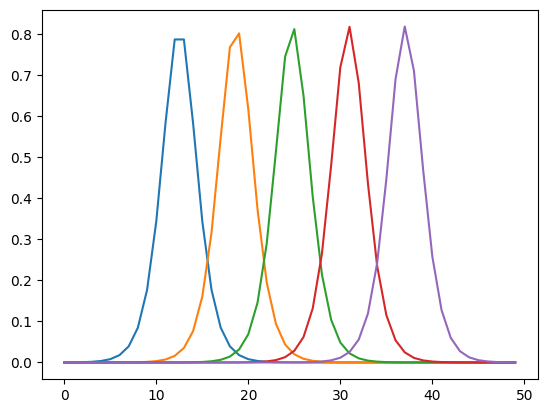

In [2]:
%autoreload
from architectures import COTGAN
from utils import DatasetSinus, DatasetSoliton, log_visualizations
from trainer import cotgan_trainer, cotgan_generator
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"
#trainset = DatasetSinus(num=32*2*12, seq_len=25, alpha=0.7, noise=0., device=device)
#testset = DatasetSinus(num=32*2*6, seq_len=25, alpha=0.7, noise=0., device="cpu")

P = 20 # period
spatial_len = 50 # M
t_steps = 5
t_range = [0, 6]
c_range = [0.5, 2]
trainset = DatasetSoliton(n_samples=32*2*4, t_steps=t_steps, P=P, spatial_len=spatial_len, t_range=t_range, c_range=c_range, device=device)
testset  = DatasetSoliton(n_samples=32*2*6,  t_steps=t_steps, P=P, spatial_len=spatial_len, t_range=t_range, c_range=c_range, device="cpu")

print(len(testset), trainset[0].shape)

plt.plot(trainset[0].T);

In [3]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["soliton"],
    description="",
    source_files=["architectures.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 1,
    "l_rate":   0.001, # for both D and G
    "l_rate_g": 0.001, # for G only
    "batch_size": 32,

    "rnn_type": "GRU", # LSTM, GRU
    "dis_rnn_num_layers": 2,
    "dis_rnn_hidden_dim": 64,
    "gen_rnn_num_layers": 1,
    "gen_rnn_hidden_dim": 64,
    "J_dim": 30,
    "hidden_dim": 64, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers
    "use_bn": False, # batch normalization

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "reg_lam":      0.01, # martingale penalty coefficient
    "sinkhorn_eps": 10.0, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations

    "Z_dim": 10,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "soliton", # "soliton" or "sines"
    "feature_dim": trainset[0].size(1),
    "max_seq_len": trainset[0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}

run["parameters"] = params
run["dataset"] = trainset.get_params()

model = COTGAN(params)
cotgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=run, continue_training=False)


# Generate random synthetic data
gen_z = cotgan_generator(model, params)

log_visualizations(testset, gen_z, run) # log pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload("./models/" + params["model_name"])

from metrics import compare_sin3_generation, sw_approx
np.random.seed(seed + 1)
torch.manual_seed(seed + 1)
par = trainset.get_params()

if params["dataset"] == "sines":
    alpha = par["alpha"]
    noise = par["noise"]
    testset2 = DatasetSinus(num=params["testset_size"], seq_len=params["max_seq_len"], alpha=alpha, noise=noise, device="cpu")
elif params["dataset"] == "soliton":
    testset2 = DatasetSoliton(n_samples=params["testset_size"], t_steps=params["max_seq_len"], P=par["P"],
                              spatial_len=par["spatial_len"],   t_range=par["t_range"], c_range=par["c_range"], device="cpu")
else:
    raise ValueError("testset2 not defined")

#testset2 = DatasetSinus(num=params["testset_size"], seq_len=params["max_seq_len"], alpha=alpha, noise=noise, device="cpu")
fake_data = cotgan_generator(model, params)

if params["dataset"] == "sines":
    mse_error = compare_sin3_generation(fake_data, 0.7, 0)
    print("ALPHA AND NOISE ARE HARD CODED IN THE METRIC FUNCTION to be 0.7 and 0.")
    run["numeric_results/sin3_generation_MSE_loss"] = mse_error

x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]

sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/SW"] = sw#.item()
run["numeric_results/SW_baseline"] = sw_baseline#.item()
run.stop()


https://app.neptune.ai/kohmann/COTGAN/e/COT-201


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/neptune/new/handler.py:168: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  self._container.define(self._path, value, wait)
Epoch: 0, G: 107.9108, D: 105.7453: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



Generating Data...Done
Real std:  [4.717188e-02 9.884555e-09]
Fake std:  [0.00049555 0.00022197]

Generating Data...Done
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.
All 19 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-201


# RUN SINUS


--n_epochs 100 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset sinus --max_seq_len 25 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu

# RUN SOLITON

python3 trainer.py --n_epochs 2000 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cuda